In [14]:
import numpy as np
import pickle
import time
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
from iminuit import Minuit, cost
from iminuit.cost import LeastSquares
hep.style.use("CMS")

In [15]:
boards = 3
input_PTRIG_name = 'Run154_list.txt'

output_file_name = 'PTRIG_154.pkl'


In [16]:
Brd = []
Ch = []
LG = []
HG = []

with open(input_PTRIG_name) as f:
    lines = f.read().split('\n')

    last_tstamp = 0  # Initialize last timestamp for continuity across files

    for i, line in enumerate(lines):
        if i > 8:
            data = line.split()

            if len(data) == 6:
                Brd.append(int(data[2]))
                Ch.append(int(data[3]))
                LG.append(int(data[4]))
                HG.append(int(data[5]))
            elif len(data) == 4:
                Brd.append(int(data[0]))
                Ch.append(int(data[1]))
                LG.append(int(data[2]))
                HG.append(int(data[3]))

Brd = np.array(Brd)
Ch = np.array(Ch)
LG = np.array(LG)
HG = np.array(HG)

In [17]:
def gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

def plot_histograms_ptrig(board_number, events, ch, brd):
    # Create subplots for each channel
    fig, axs = plt.subplots(4, 16, figsize=(32, 8),sharey=True,sharex=True)
    fig.suptitle(f'Board {board_number} - LG Histograms', fontsize=20, y = 1)
    plt.rcParams['figure.facecolor']='white'
    plt.rcParams['savefig.facecolor']='white'
    plt.rcParams['savefig.bbox']='tight'
    
    ptrigs = []
    ptrigmeans = []
    ptrigsigmas = []
    
    for i in range(4):
        for j in range(16):
            channel_number = i * 16 + j
            mask = (ch == channel_number) & (brd == board_number) & (events != 0) & (events < 400)
            
            if(len(events[mask]) != 0):
                # Create histogram
                h, bins = np.histogram(events[mask], bins=200, range=(np.mean(events[mask])-100, np.mean(events[mask])+100))
                bin_centers = 0.5 * (bins[:-1] + bins[1:])
                errors = np.sqrt(h)
            
                # Plot error bar plot
                axs[i, j].errorbar(bin_centers, h, yerr=errors, fmt='o', ecolor='tab:blue', color='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0)
        
                axs[i, j].set_title(f'Channel {channel_number}', fontsize = 10, pad=-15, loc='center')
            
                initial_params = [max(h),np.mean(events[mask]),np.std(events[mask])]
                mask = h > 0
            
                m = Minuit(LeastSquares(bin_centers[mask], h[mask], errors[mask], gauss), A=initial_params[0], mu=initial_params[1], sigma=initial_params[2])
                # Set limits for the sigma parameter
                m.limits["sigma"] = (0, None)
                m.limits["A"] = (0, max(h))
                # Perform the fit
                m.migrad()
                # Get the fitted parameters
                fitted_params = m.values
            
                A_fit = fitted_params['A']
                mu_fit = fitted_params['mu']
                sigma_fit = fitted_params['sigma']
    
                ptrigsigmas.append(sigma_fit)
                ptrigmeans.append(mu_fit)
    
                x = np.linspace(-10, 300, 1000)
                y_fit = gauss(x, A_fit, mu_fit, sigma_fit)

                axs[i, j].plot(x, y_fit, 'tab:orange', label='Fit') 
            else:
                ptrigsigmas.append(100)
                ptrigmeans.append(0)
            
            # Set labels
            if i == 7:  # Bottom most row
                axs[i, j].set_xlabel('Value [ADC]', fontsize = 10)
            if j == 0:  # Left most column
                axs[i, j].set_ylabel('Count', fontsize = 10)

    # Adjust layout   
    plt.tight_layout(pad=0.0)
    plt.subplots_adjust(hspace=0.0, wspace=0.0)
 
    plt.show()
    ptrigs.append(ptrigmeans)
    ptrigs.append(ptrigsigmas)
    return ptrigs

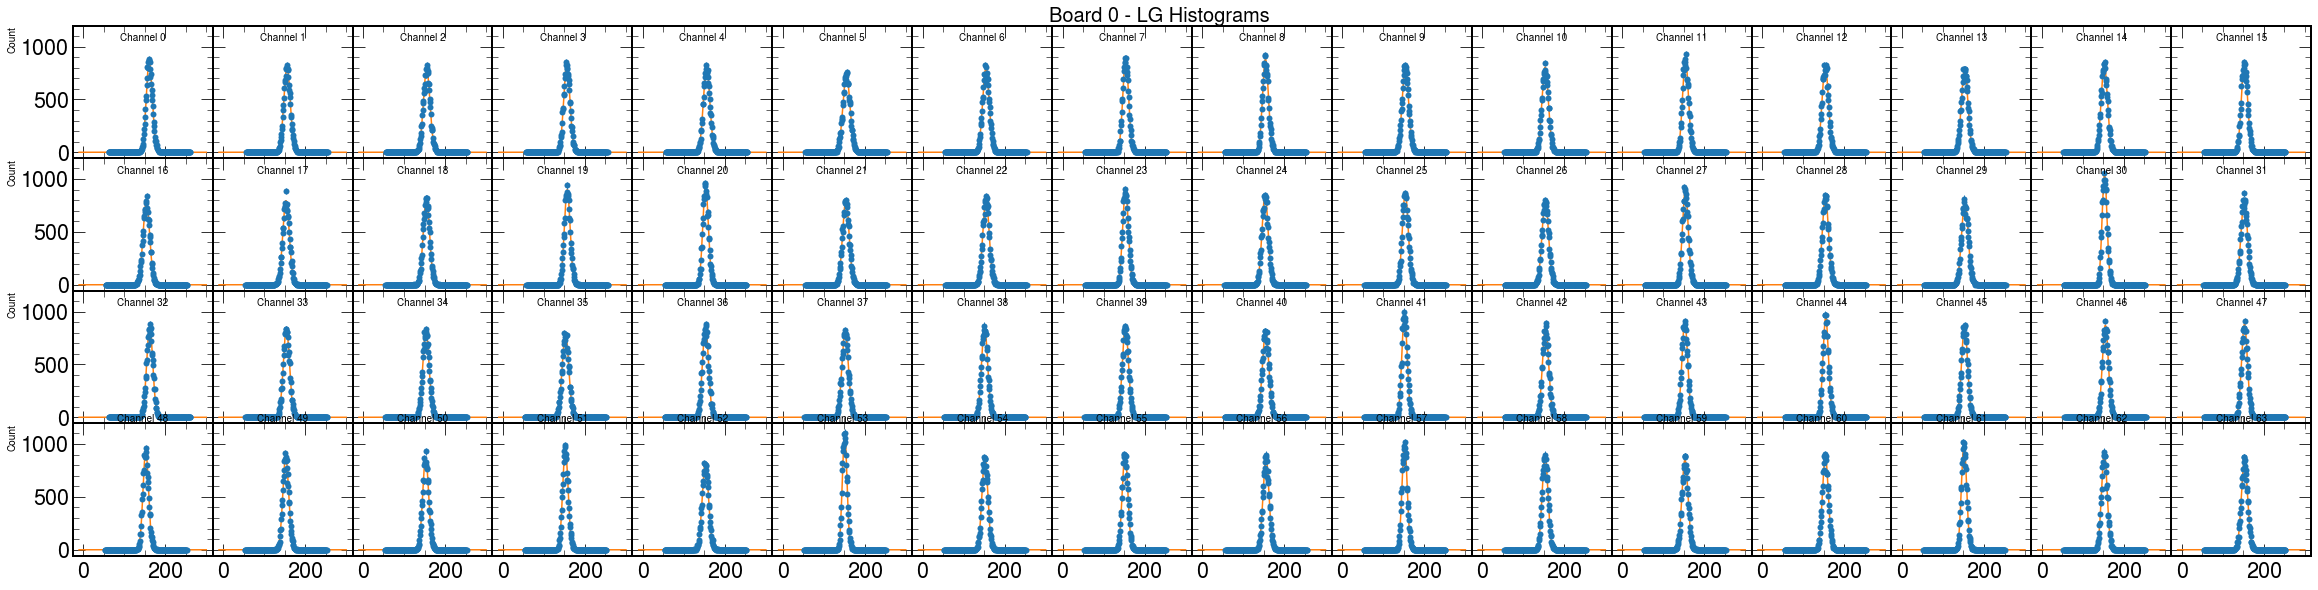

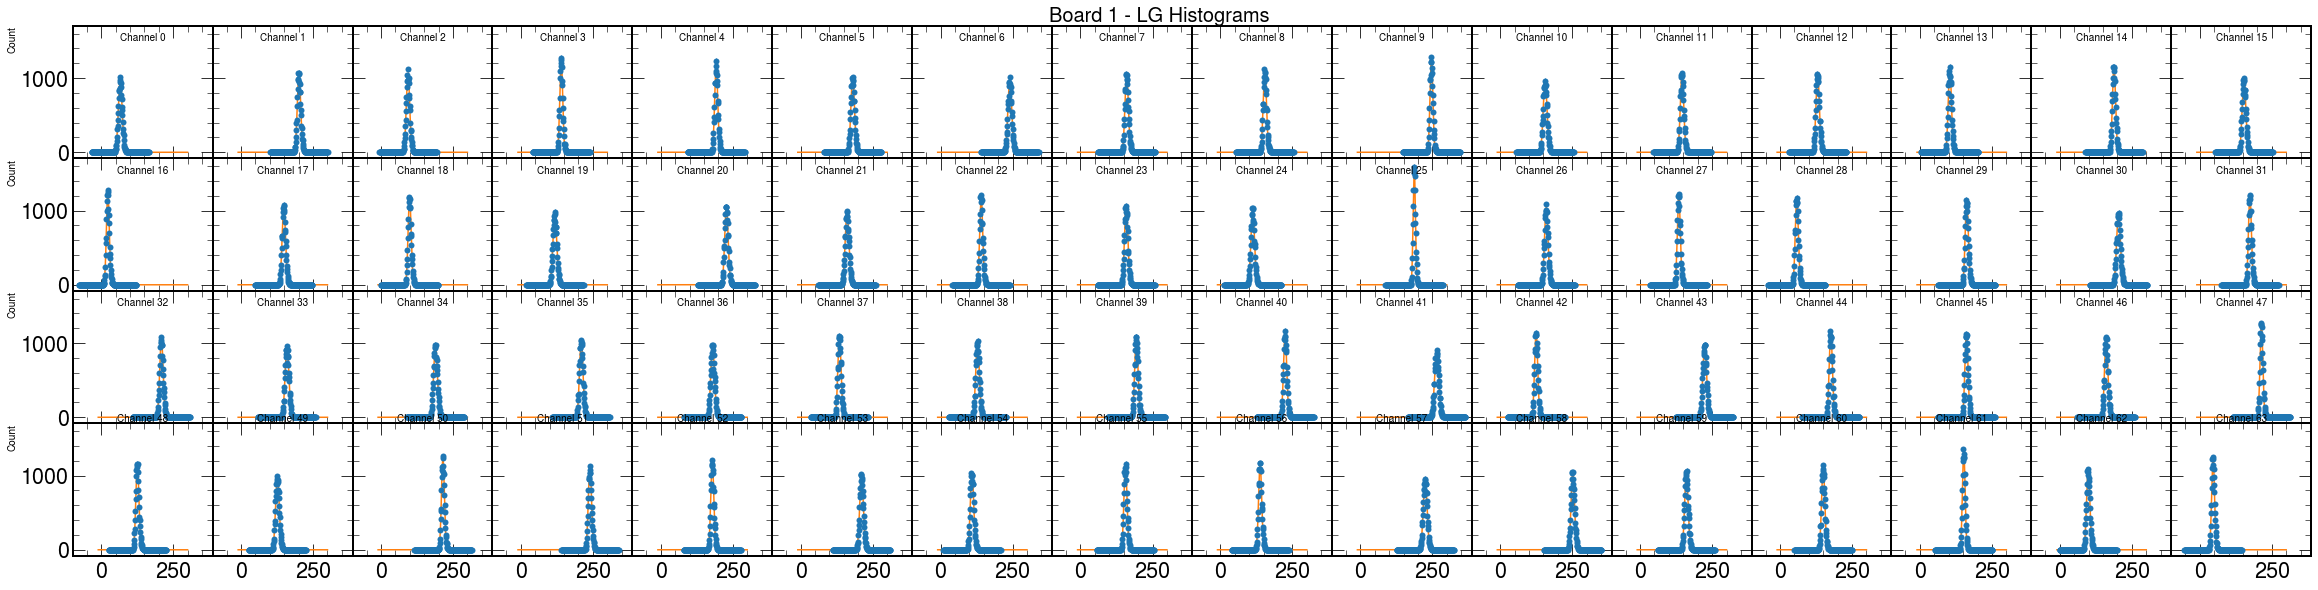

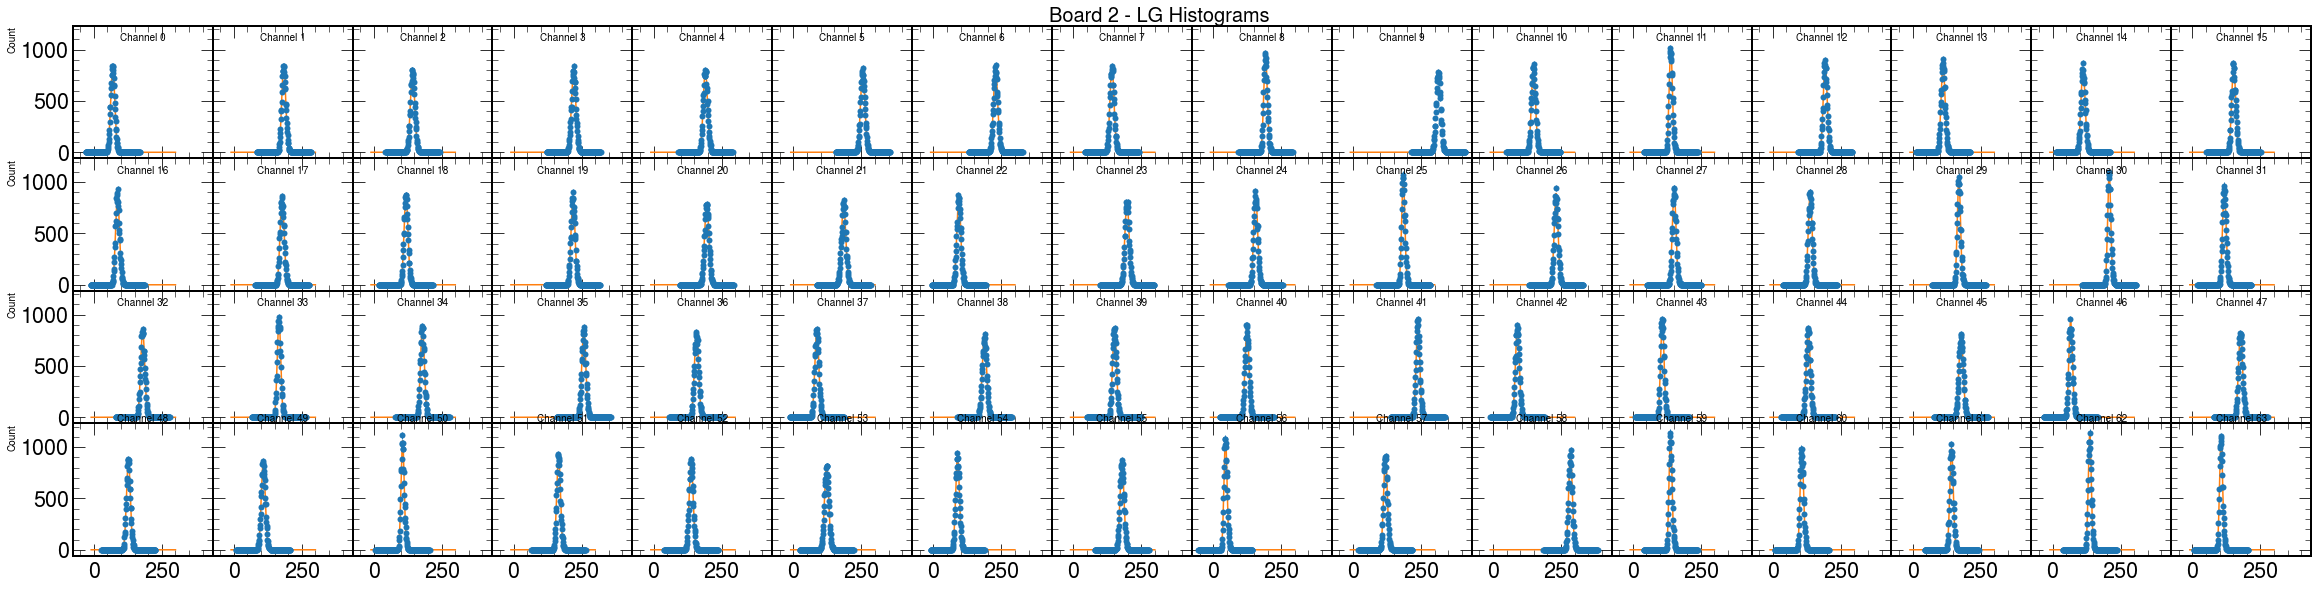

In [18]:
LGptrigs = []
LGptrigs.append(plot_histograms_ptrig(0, LG, Ch, Brd))
LGptrigs.append(plot_histograms_ptrig(1, LG, Ch, Brd))
LGptrigs.append(plot_histograms_ptrig(2, LG, Ch, Brd))

153.67522030621961
7.348349164362489


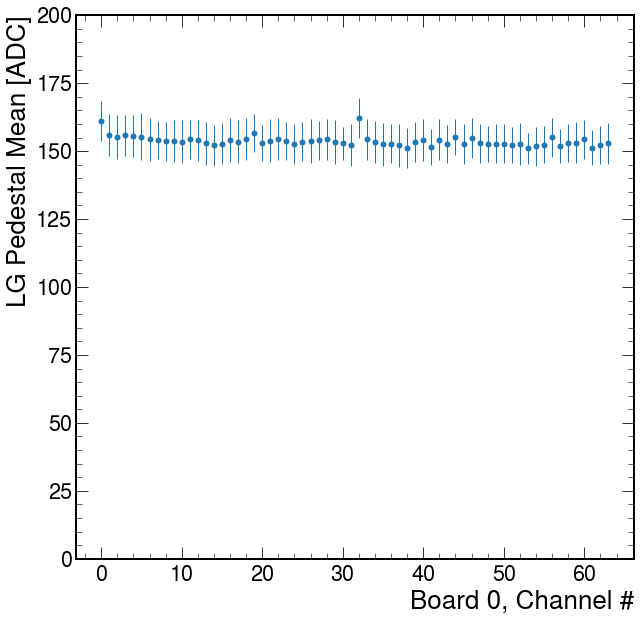

In [19]:
plt.errorbar(range(0,64), LGptrigs[0][0], yerr=LGptrigs[0][1], fmt='o', ecolor='tab:blue', color='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0)

plt.ylim(0,200)
plt.xlabel("Board 0, Channel #")
plt.ylabel("LG Pedestal Mean [ADC]")
print(np.mean(LGptrigs[0][0]))
print(np.mean(LGptrigs[0][1]))

161.93311924214936
5.748492333296676


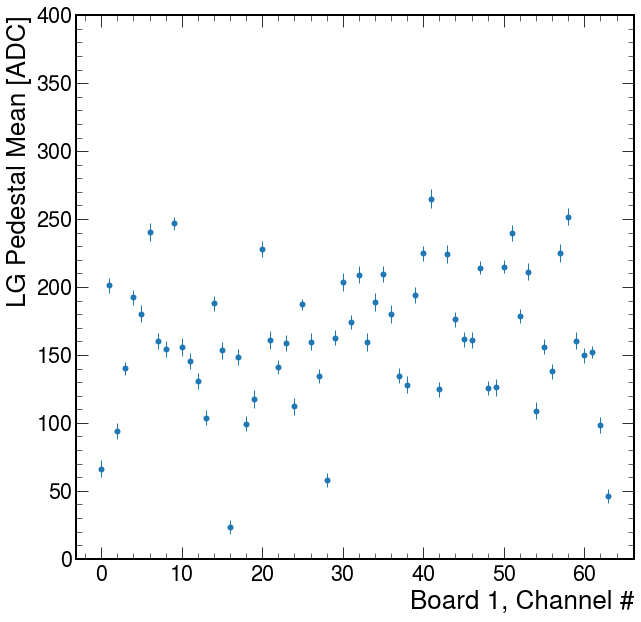

In [20]:
plt.errorbar(range(0,64), LGptrigs[1][0], yerr=LGptrigs[1][1], fmt='o', ecolor='tab:blue', color='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0)

plt.ylim(0,400)
plt.xlabel("Board 1, Channel #")
plt.ylabel("LG Pedestal Mean [ADC]")
print(np.mean(LGptrigs[1][0]))
print(np.mean(LGptrigs[1][1]))


156.5092940860802
7.0568005717496565


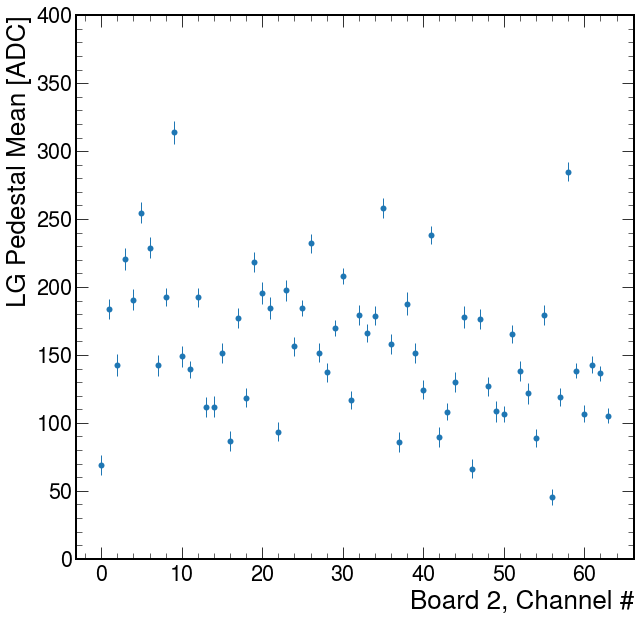

In [21]:
plt.errorbar(range(0,64), LGptrigs[2][0], yerr=LGptrigs[2][1], fmt='o', ecolor='tab:blue', color='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0)

plt.ylim(0,400)
plt.xlabel("Board 2, Channel #")
plt.ylabel("LG Pedestal Mean [ADC]")
print(np.mean(LGptrigs[2][0]))
print(np.mean(LGptrigs[2][1]))

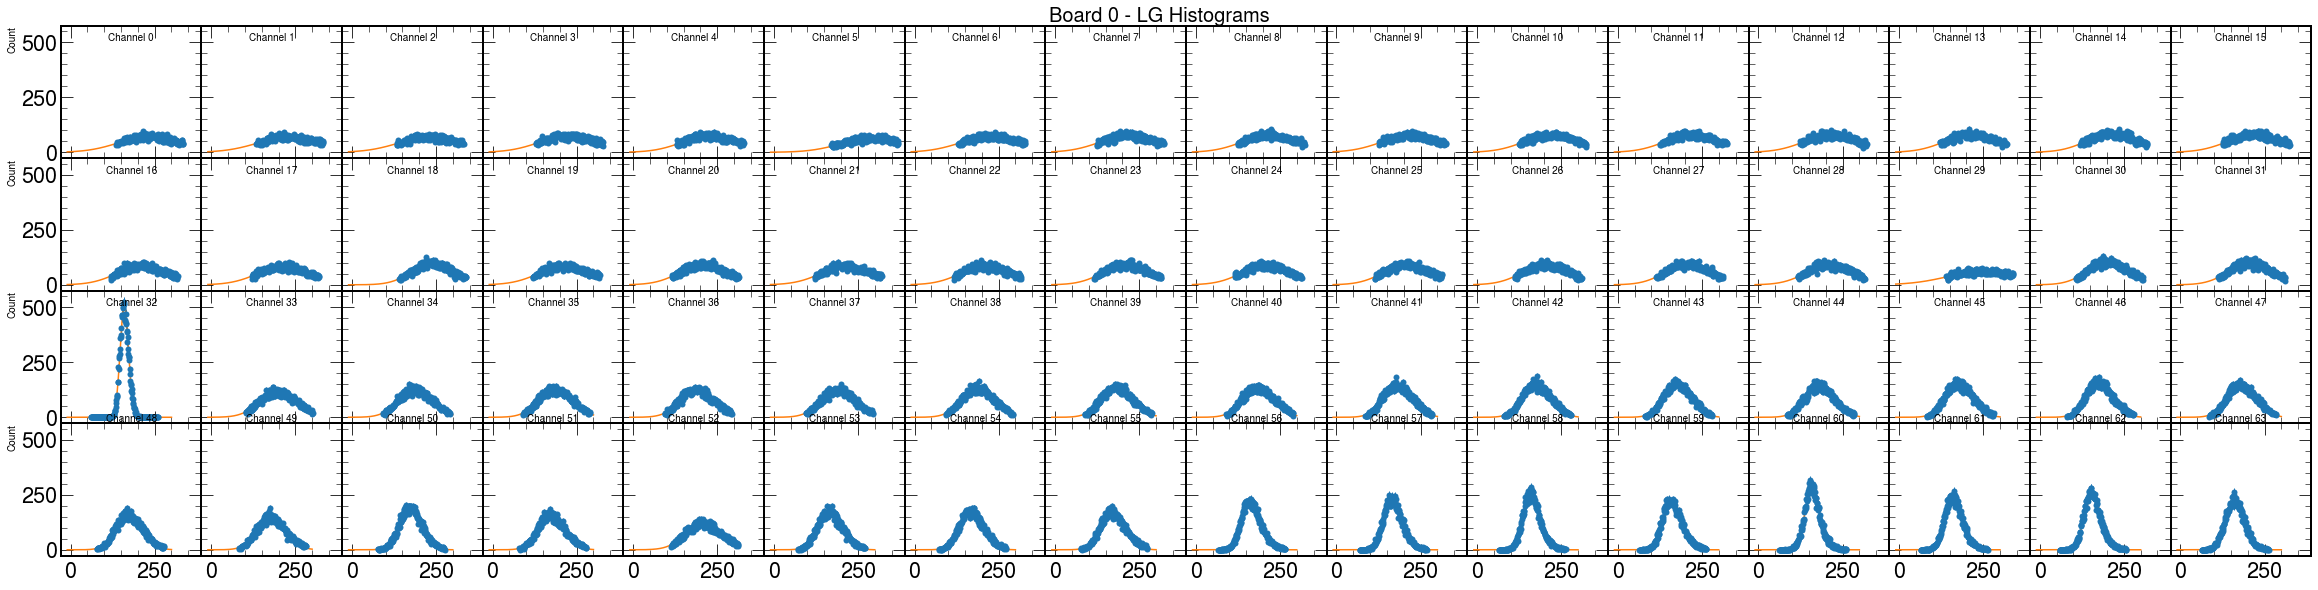

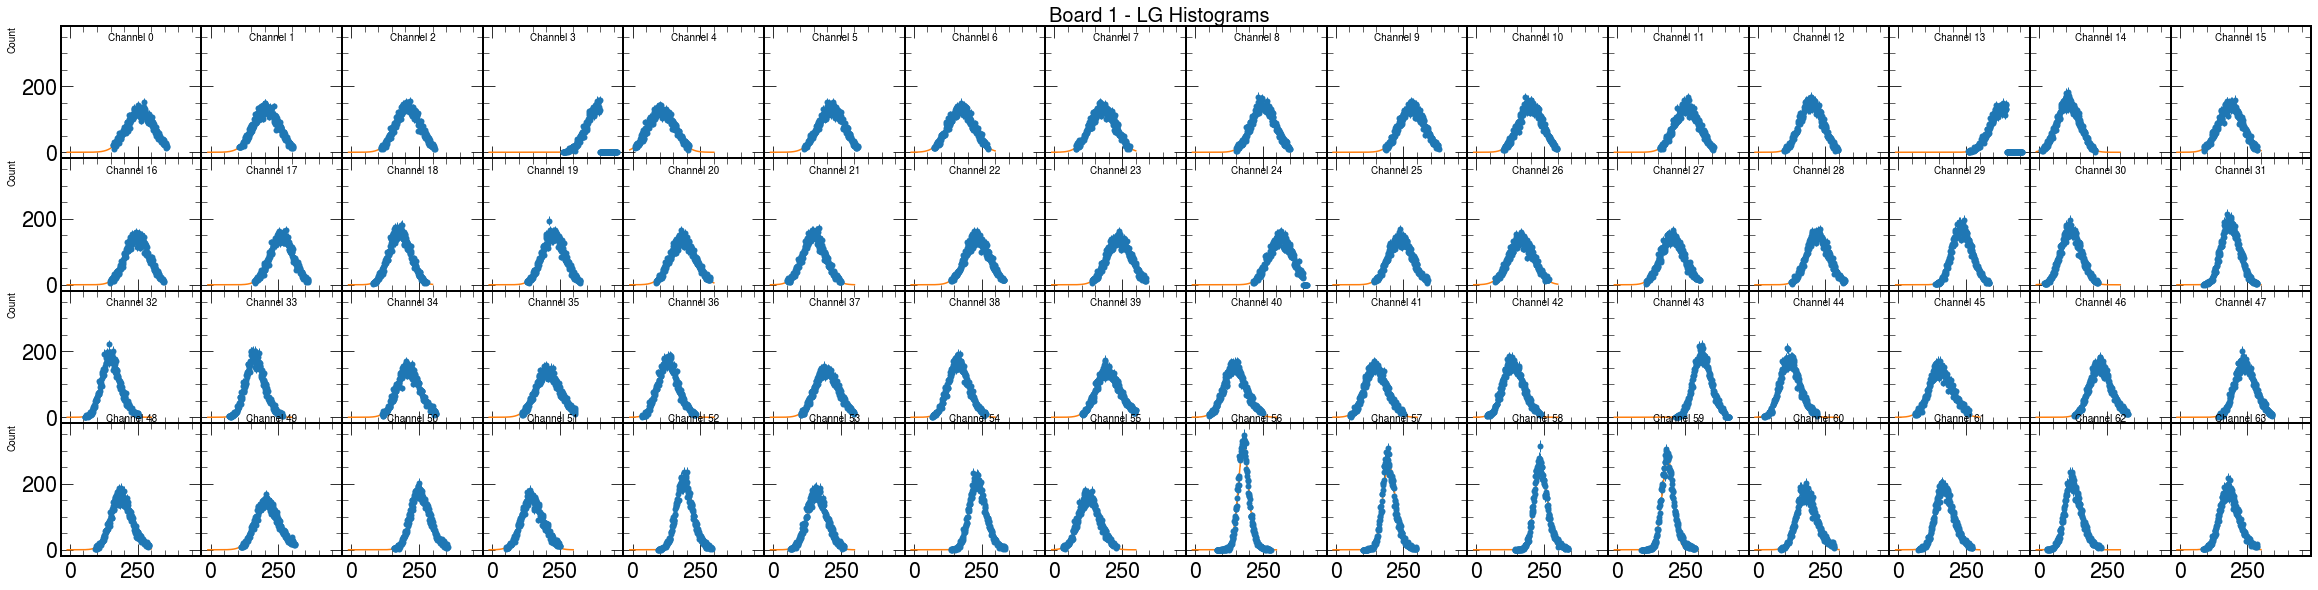

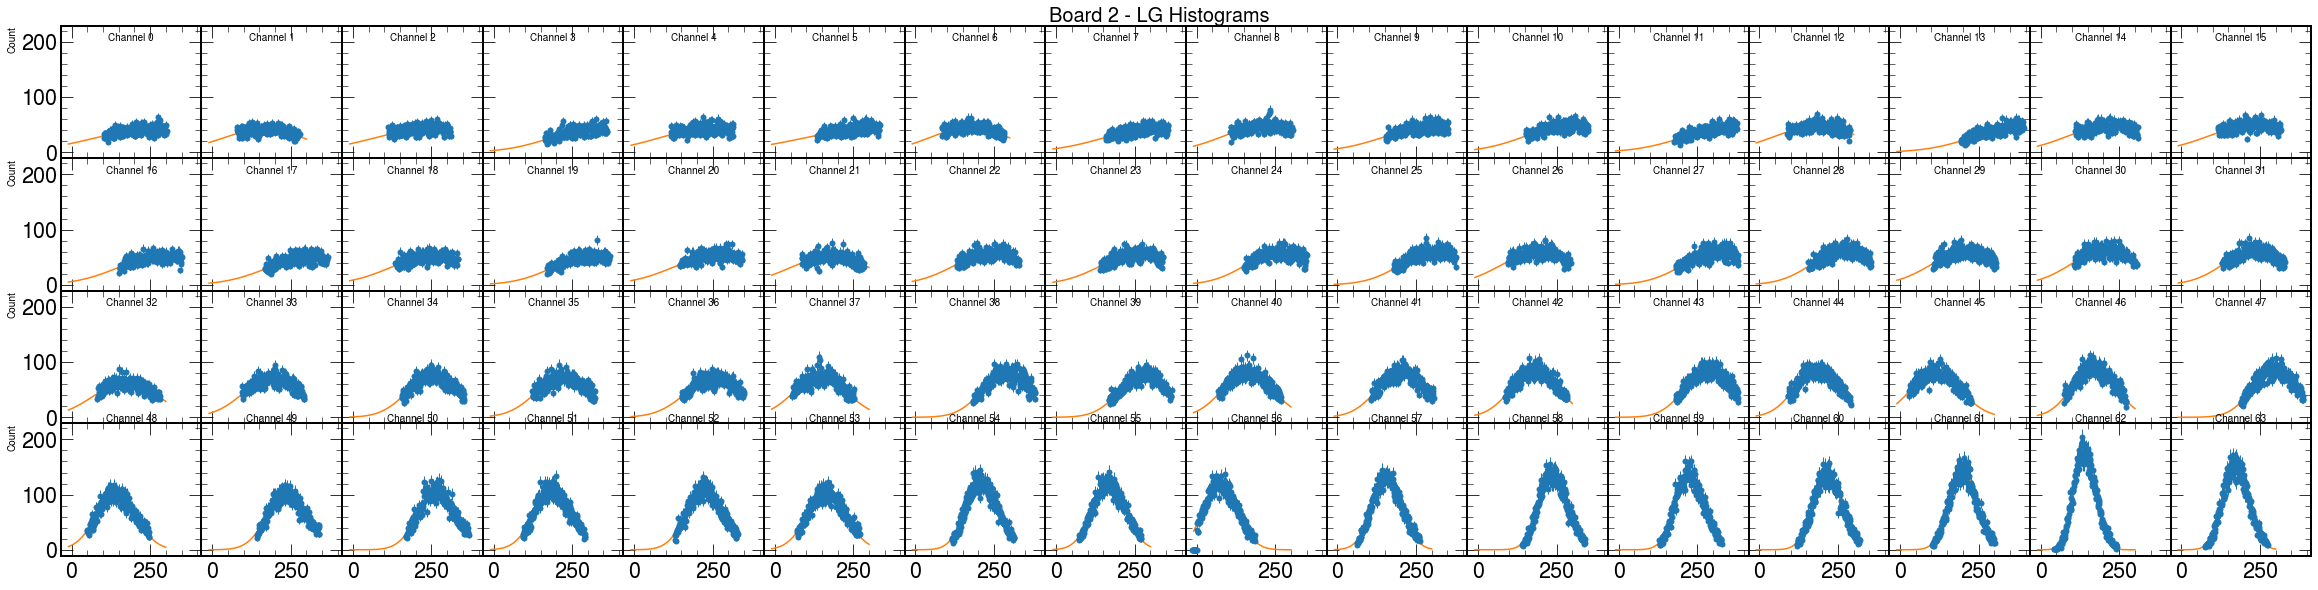

In [22]:
HGptrigs = []
HGptrigs.append(plot_histograms_ptrig(0, HG, Ch, Brd))
HGptrigs.append(plot_histograms_ptrig(1, HG, Ch, Brd))
HGptrigs.append(plot_histograms_ptrig(2, HG, Ch, Brd))

Text(0, 1, 'HG Pedestal Mean [ADC]')

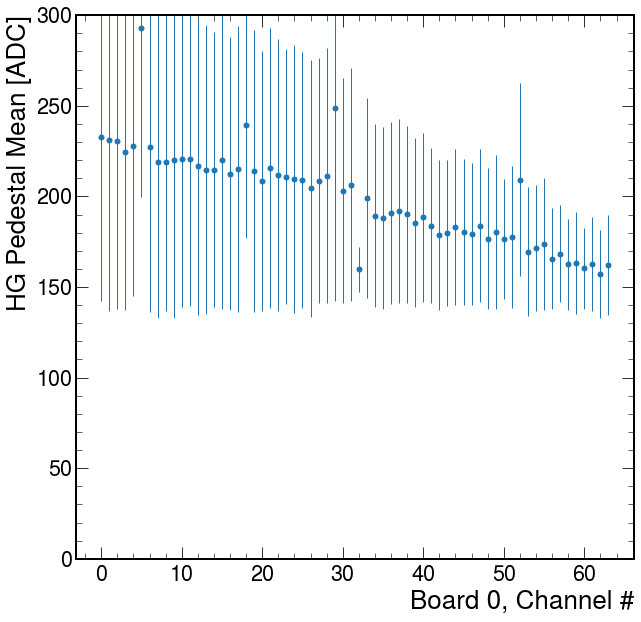

In [23]:
plt.errorbar(range(0,64), HGptrigs[0][0], yerr=HGptrigs[0][1], fmt='o', ecolor='tab:blue', color='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0)

plt.ylim(0,300)
plt.xlabel("Board 0, Channel #")
plt.ylabel("HG Pedestal Mean [ADC]")

Text(0, 1, 'HG Pedestal Mean [ADC]')

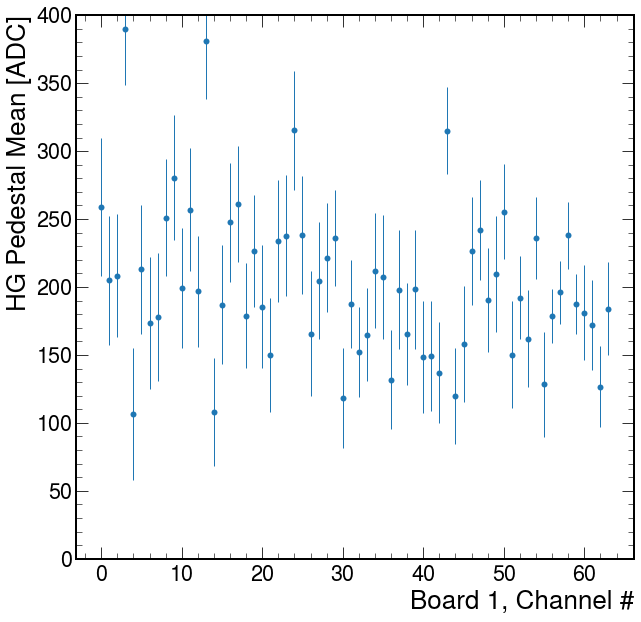

In [24]:
plt.errorbar(range(0,64), HGptrigs[1][0], yerr=HGptrigs[1][1], fmt='o', ecolor='tab:blue', color='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0)

plt.ylim(0,400)
plt.xlabel("Board 1, Channel #")
plt.ylabel("HG Pedestal Mean [ADC]")

Text(0, 1, 'HG Pedestal Mean [ADC]')

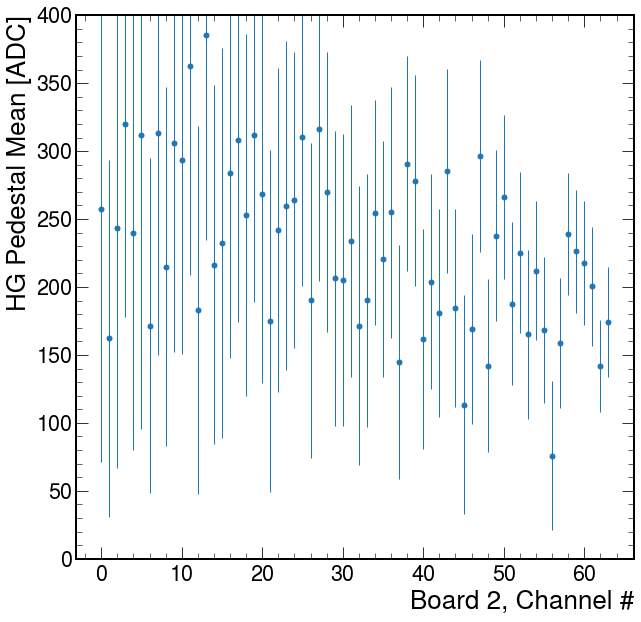

In [25]:
plt.errorbar(range(0,64), HGptrigs[2][0], yerr=HGptrigs[2][1], fmt='o', ecolor='tab:blue', color='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0)

plt.ylim(0,400)
plt.xlabel("Board 2, Channel #")
plt.ylabel("HG Pedestal Mean [ADC]")

In [26]:
# Iterate over LGptrigs and HGptrigs to extract data
for board_num in range(len(LGptrigs)):
    for channel_num in range(len(LGptrigs[board_num][0])):
        lg_mean = LGptrigs[board_num][0][channel_num]
        lg_sigma = LGptrigs[board_num][1][channel_num]
        hg_mean = HGptrigs[board_num][0][channel_num]
        hg_sigma = HGptrigs[board_num][1][channel_num]
        
        # Append data to the list
        data.append({
            'board': board_num,
            'channel': channel_num,
            'LG_mean': lg_mean,
            'LG_sigma': lg_sigma,
            'HG_mean': hg_mean,
            'HG_sigma': hg_sigma
        })

# Create DataFrame
df = pd.DataFrame(data)

# Save DataFrame as pickle file
df.to_pickle(output_file_name)